In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import operator

In [2]:
def load_train(data_dir:str) -> pd.DataFrame():
    train_transaction_df = pd.read_csv(os.path.join(data_dir, "train_transaction.csv"))
    train_identity_df = pd.read_csv(os.path.join(data_dir, "train_identity.csv"))
    train_transaction_df = train_transaction_df.merge(train_identity_df,how='left',on='TransactionID')

    return train_transaction_df

In [3]:
train_data=load_train(data_dir="../data-fraud-detection/")

In [4]:
train_data.head(n=10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
rows=train_data.shape[0]
columns=train_data.shape[1]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
train_data=reduce_mem_usage(train_data)

Memory usage after optimization is: 650.48 MB
Decreased by 66.8%


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB


In [9]:
# 2.76 % of features have more then 90 % of values NaN
sum=0
for col in train_data.columns:
    sum+=train_data[col].isna().sum()/rows>0.75
    
print(sum/columns*100)

47.926267281105986


DROPPING FEATURES WITH NR OF NANS > 90%

In [10]:
aux=train_data.copy()
aux.drop(aux.columns[aux.apply(lambda col: col.isnull().sum()/rows > 0.90)],axis=1,inplace=True)
aux

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


TRANSFORMING STRING VALUES

In [11]:
aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 422 entries, TransactionID to DeviceInfo
dtypes: float16(344), float32(45), int16(1), int32(2), int8(1), object(29)
memory usage: 630.2+ MB


In [12]:
aux.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


TRANBSFORM TRANSACTIONDT TO HOURS AND DAYS


In [13]:
aux['TransactionHour']=aux['TransactionDT']/3600 % 24
aux['TransactionDay']=aux['TransactionDT']/(3600*24)%7
aux.drop(['TransactionDT'],axis=1,inplace=True)
aux['TransactionHour']

0          0.000000
1          0.000278
2          0.019167
3          0.027500
4          0.029444
            ...    
590535    23.957500
590536    23.958056
590537    23.966389
590538    23.968889
590539    23.980833
Name: TransactionHour, Length: 590540, dtype: float64

In [14]:
aux.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay
0,2987000,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
1,2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000278,1.000012
2,2987002,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019167,1.000799
3,2987003,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027500,1.001146
4,2987004,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.029444,1.001227


In [15]:
aux.select_dtypes(include=["object"]).columns.tolist()

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

Transforing String Values-continue

In [16]:
aux['P_emaildomain'].unique()
aux['P_emaildomain'].fillna(value=aux['R_emaildomain'],inplace=True)
aux['R_emaildomain'].fillna(value=aux['P_emaildomain'],inplace=True)
aux[['P_emaildomain','R_emaildomain']]

,P_emaildomain,R_emaildomain
0,NaN,NaN
1,gmail.com,gmail.com
2,outlook.com,outlook.com
3,yahoo.com,yahoo.com
4,gmail.com,gmail.com
...,...,...
590535,NaN,NaN
590536,gmail.com,gmail.com
590537,gmail.com,gmail.com
590538,aol.com,aol.com


In [17]:
aux['P_emaildomain'].fillna(value='missing',inplace=True)
aux['R_emaildomain'].fillna(value='missing',inplace=True)
aux[['P_emaildomain','R_emaildomain']]

,P_emaildomain,R_emaildomain
0,missing,missing
1,gmail.com,gmail.com
2,outlook.com,outlook.com
3,yahoo.com,yahoo.com
4,gmail.com,gmail.com
...,...,...
590535,missing,missing
590536,gmail.com,gmail.com
590537,gmail.com,gmail.com
590538,aol.com,aol.com


In [18]:
print(((aux['P_emaildomain']!=aux['R_emaildomain']) & (aux['isFraud']==1) ).sum())
print((aux['P_emaildomain']!=aux['R_emaildomain'] ).sum())
print(682/23723*100) #fraud when different domains

682
23723
2.87484719470556


In [19]:
aux['P_emaildomain'].unique()

array(['missing', 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'aim.com',
       'frontiernet.net', 'windstream.net', 'frontier.com', 'outlook.es',
       'mac.com', 'netzero.com', 'web.de', 'scranton.edu', 'twc.com',
       'cableone.net', 'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com',
       'ptd.net', 'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

<AxesSubplot:ylabel='Density'>

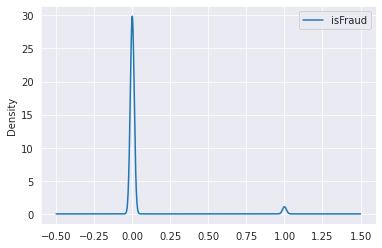

In [20]:
aux.plot(x='TransactionHour',y='isFraud',kind='kde')

In [21]:
aux_isFraud=aux.copy()
aux_isFraud=aux_isFraud.loc[aux_isFraud['isFraud']==True]
aux_isFraud

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay
203,2987203,1,445.00000,W,18268,583.0,150.0,visa,226.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.933333,1.038889
240,2987240,1,37.09375,C,13413,103.0,185.0,visa,137.0,credit,...,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.053611,1.043900
243,2987243,1,37.09375,C,13413,103.0,185.0,visa,137.0,credit,...,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.068333,1.044514
245,2987245,1,37.09375,C,13413,103.0,185.0,visa,137.0,credit,...,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,1.081944,1.045081
288,2987288,1,155.50000,C,16578,545.0,185.0,visa,226.0,credit,...,NaN,NaN,F,F,F,F,mobile,NaN,1.273889,1.053079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590361,3577361,1,1224.00000,W,3278,453.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.935556,0.955648
590364,3577364,1,69.93750,C,5812,408.0,185.0,mastercard,224.0,debit,...,NaN,NaN,F,F,T,F,mobile,SAMSUNG SM-J700M Build/MMB29K,22.976667,0.957361
590368,3577368,1,100.00000,H,6758,399.0,150.0,american express,146.0,credit,...,2208x1242,match_status:1,T,F,F,T,mobile,iOS Device,23.021389,0.959225
590372,3577372,1,117.00000,W,14037,111.0,150.0,visa,226.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.043889,0.960162


In [22]:
aux_isFraud["TransactionHour"] = np.floor(aux_isFraud["TransactionHour"].astype("float32")).astype("int8").astype("category")

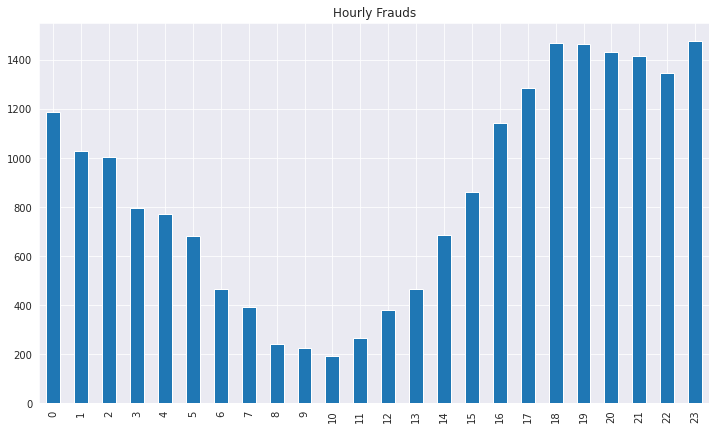

In [23]:
ax = aux_isFraud["TransactionHour"].value_counts().sort_index().plot.bar(figsize=(12, 7))
ax.set_title("Hourly Frauds");

In [24]:
aux_isFraud["TransactionDay"] = np.floor(aux_isFraud["TransactionDay"].astype("float32")).astype("int8").astype("category")

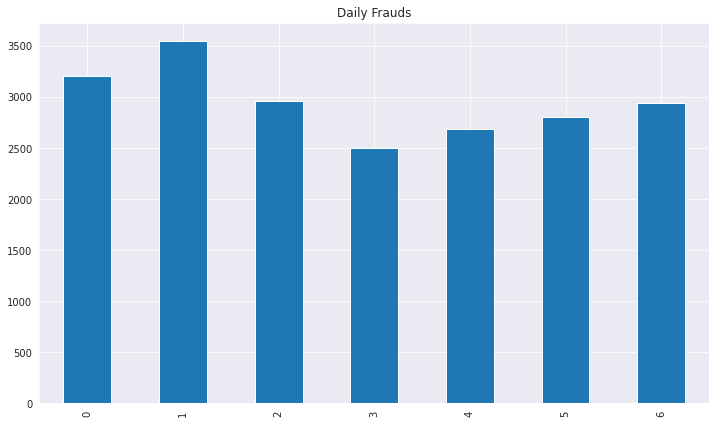

In [25]:
ax = aux_isFraud["TransactionDay"].value_counts().sort_index().plot.bar(figsize=(12, 7))
ax.set_title("Daily Frauds");

In [26]:
aux['DifferentEmailDomain']=(aux['P_emaildomain'] != aux['R_emaildomain']).astype(int)
aux.drop(['P_emaildomain'],axis=1,inplace=True)
aux.drop(['R_emaildomain'],axis=1,inplace=True)

In [27]:
aux.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionHour,TransactionDay,DifferentEmailDomain
0,2987000,0,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0
1,2987001,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000278,1.000012,0
2,2987002,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019167,1.000799,0
3,2987003,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027500,1.001146,0
4,2987004,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.029444,1.001227,0


In [28]:
remain_string=aux.select_dtypes(include=["object"]).columns.tolist()
for col in remain_string :
    if len(aux[col].unique()) > 5 :
        aux.drop(col,axis=1,inplace=True)

remain_string=aux.select_dtypes(include=["object"]).columns.tolist()
for col in remain_string:
    aux[col].fillna(value="missing",inplace=True)
    aux[col]=aux[col].astype('category')

    aux[col+'_cat']=aux[col].cat.codes
    aux.drop(col,axis=1,inplace=True)
aux.head(n=10)

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_15_cat,id_16_cat,id_28_cat,id_29_cat,id_34_cat,id_35_cat,id_36_cat,id_37_cat,id_38_cat,DeviceType_cat
0,2987000,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,3,2,2,2,4,2,2,2,2,1
1,2987001,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,3,2,2,2,4,2,2,2,2,1
2,2987002,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,...,3,2,2,2,4,2,2,2,2,1
3,2987003,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,...,3,2,2,2,4,2,2,2,2,1
4,2987004,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,...,1,1,1,1,3,1,0,1,1,2
5,2987005,0,49.0,5937,555.0,150.0,226.0,272.0,87.0,36.0,...,3,2,2,2,4,2,2,2,2,1
6,2987006,0,159.0,12308,360.0,150.0,166.0,126.0,87.0,0.0,...,3,2,2,2,4,2,2,2,2,1
7,2987007,0,422.5,12695,490.0,150.0,226.0,325.0,87.0,NaN,...,3,2,2,2,4,2,2,2,2,1
8,2987008,0,15.0,2803,100.0,150.0,226.0,337.0,87.0,NaN,...,1,1,1,1,2,1,0,0,1,2
9,2987009,0,117.0,17399,111.0,150.0,224.0,204.0,87.0,19.0,...,3,2,2,2,4,2,2,2,2,1


In [29]:
remain_string=aux.select_dtypes(include=["object"]).columns.tolist()

In [30]:
aux.describe()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_15_cat,id_16_cat,id_28_cat,id_29_cat,id_34_cat,id_35_cat,id_36_cat,id_37_cat,id_38_cat,DeviceType_cat
count,5.905400e+05,590540.000000,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,238269.0,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,3.282270e+06,0.034990,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,NaN,...,2.427553,1.668669,1.632184,1.634396,3.837403,1.654289,1.534238,1.709557,1.636084,0.950012
std,1.704744e+05,0.183755,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,NaN,...,1.068432,0.667962,0.700504,0.696917,0.446413,0.663430,0.838376,0.556321,0.694144,0.485741
min,2.987000e+06,0.000000,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,3.0,...,3.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000
50%,3.282270e+06,0.000000,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,8.0,...,3.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000
75%,3.429904e+06,0.000000,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,24.0,...,3.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,3.577539e+06,1.000000,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,10288.0,...,3.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [31]:
columns_list = aux.columns.values.tolist()

In [32]:
from typing import Union


def fill_nans(df: pd.DataFrame, operation: Union[str, float, int] = "mean") -> pd.DataFrame:
    if isinstance(operation, str):
        assert operation in ("mean", "median")

    is_na_columns = df.isnull().any(axis=0)
    columns_with_na = is_na_columns[is_na_columns == True].index
    df_with_nans = df[columns_with_na]
    df_with_nans = df_with_nans.astype("float32")
    if isinstance(operation, str):
        if operation == "mean":
            fill_values = df_with_nans.mean(axis=0, skipna=True)
        else:
            fill_values = df_with_nans.median(axis=0, skipna=True)

        for column in columns_with_na:
            df[column] = df[column].fillna(fill_values[column])
    else:
        fill_value = operation
        df[columns_with_na] = df[columns_with_na].fillna(fill_value)

    return df


In [33]:
aux = fill_nans(aux, operation="mean")
print(aux.isna().sum().sum())

0


In [34]:
aux.head()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_15_cat,id_16_cat,id_28_cat,id_29_cat,id_34_cat,id_35_cat,id_36_cat,id_37_cat,id_38_cat,DeviceType_cat
0,2987000,0,68.5,13926,362.5,150.0,142.0,315.0,87.0,19.0,...,3,2,2,2,4,2,2,2,2,1
1,2987001,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,118.5,...,3,2,2,2,4,2,2,2,2,1
2,2987002,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,...,3,2,2,2,4,2,2,2,2,1
3,2987003,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,118.5,...,3,2,2,2,4,2,2,2,2,1
4,2987004,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,118.5,...,1,1,1,1,3,1,0,1,1,2


In [35]:
corr_mat=aux.corr().abs()

In [36]:
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))

In [37]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(len(to_drop))
print(to_drop)

184
['C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C14', 'V5', 'V11', 'V13', 'V16', 'V18', 'V20', 'V21', 'V22', 'V28', 'V30', 'V31', 'V32', 'V33', 'V34', 'V36', 'V40', 'V43', 'V45', 'V49', 'V50', 'V51', 'V52', 'V54', 'V57', 'V58', 'V60', 'V63', 'V64', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V76', 'V79', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V94', 'V96', 'V97', 'V101', 'V102', 'V103', 'V105', 'V106', 'V113', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134', 'V137', 'V140', 'V143', 'V145', 'V147', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V163', 'V164', 'V167', 'V168', 'V177', 'V178', 'V179', 'V182', 'V183', 'V190', 'V192', 'V193', 'V196', 'V197', 'V198', 'V199', 'V201', 'V202', 'V203', 'V204', 'V207', 'V211', 'V212', 'V213', 'V216', 'V218', 'V219', 'V222', 'V225', 'V231', 'V232', 'V233', 'V236', 'V237', 'V239', 'V243', 'V244', 'V245', 'V249', 'V251', 'V253', 'V254', 'V256', 'V257', 'V259', 'V265', 'V266', 'V

In [38]:
aux2=aux.copy()
aux2.drop(aux2[to_drop],axis=1,inplace=True)
aux2.head(n=15)

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,card4_cat,card6_cat,M1_cat,M4_cat,M5_cat,M6_cat,M7_cat,id_12_cat,id_34_cat,DeviceType_cat
0,2987000,0,68.500,13926,362.5,150.0,142.0,315.00,87.0000,19.0,...,1,1,1,2,0,1,2,2,4,1
1,2987001,0,29.000,2755,404.0,150.0,102.0,325.00,87.0000,118.5,...,2,1,2,0,1,1,2,2,4,1
2,2987002,0,59.000,4663,490.0,150.0,166.0,330.00,87.0000,287.0,...,4,2,1,0,0,0,0,2,4,1
3,2987003,0,50.000,18132,567.0,150.0,117.0,476.00,87.0000,118.5,...,2,2,2,0,1,0,2,2,4,1
4,2987004,0,50.000,4497,514.0,150.0,102.0,420.00,87.0000,118.5,...,2,1,2,3,2,2,2,1,3,2
5,2987005,0,49.000,5937,555.0,150.0,226.0,272.00,87.0000,36.0,...,4,2,1,1,0,1,2,2,4,1
6,2987006,0,159.000,12308,360.0,150.0,166.0,126.00,87.0000,0.0,...,4,2,1,0,0,0,1,2,4,1
7,2987007,0,422.500,12695,490.0,150.0,226.0,325.00,87.0000,118.5,...,4,2,2,0,0,0,2,2,4,1
8,2987008,0,15.000,2803,100.0,150.0,226.0,337.00,87.0000,118.5,...,4,2,2,3,2,2,2,1,2,2
9,2987009,0,117.000,17399,111.0,150.0,224.0,204.00,87.0000,19.0,...,2,2,1,0,1,1,2,2,4,1


In [39]:
Xtrain, Xtest = train_test_split(aux2, test_size=0.2)

In [40]:
Xtrain.drop(['TransactionID'],axis=1,inplace=True)
Xtrain.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,card4_cat,card6_cat,M1_cat,M4_cat,M5_cat,M6_cat,M7_cat,id_12_cat,id_34_cat,DeviceType_cat
173132,1,97.00000,15066,170.0,150.0,102.0,126.00,87.0000,118.5,1.0,...,2,1,2,0,1,0,2,2,4,1
334483,0,445.00000,16659,170.0,150.0,226.0,299.00,87.0000,118.5,2.0,...,4,1,2,1,1,1,2,2,4,1
458212,1,35.96875,9633,130.0,185.0,138.0,290.75,86.8125,118.5,7.0,...,4,2,2,2,2,2,2,1,4,0
12842,0,47.93750,16317,555.0,150.0,226.0,436.00,87.0000,3.0,10.0,...,4,2,1,3,2,0,0,2,4,1
97746,0,24.18750,15885,545.0,185.0,138.0,290.75,86.8125,118.5,2.0,...,4,2,2,2,2,2,2,2,4,1


In [41]:
Xtest.drop(['TransactionID'],axis=1,inplace=True)
Xtest.head()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,card4_cat,card6_cat,M1_cat,M4_cat,M5_cat,M6_cat,M7_cat,id_12_cat,id_34_cat,DeviceType_cat
530690,0,50.000000,7653,216.0,150.0,226.0,177.00,87.0000,118.5,1.0,...,4,1,2,3,2,2,2,1,3,0
79420,0,75.000000,7861,494.0,150.0,226.0,204.00,87.0000,118.5,1.0,...,4,1,2,3,2,2,2,1,4,1
33841,0,50.000000,17059,360.0,150.0,226.0,177.00,87.0000,118.5,1.0,...,4,2,2,3,2,2,2,1,3,0
252210,0,107.937500,4526,571.0,150.0,226.0,181.00,87.0000,11.0,2.0,...,4,2,1,3,2,1,0,2,4,1
445756,0,5.777344,2650,142.0,185.0,224.0,290.75,86.8125,118.5,1.0,...,2,2,2,2,2,2,2,1,4,2


In [42]:
Ytrain= Xtrain['isFraud']
Ytest= Xtest['isFraud']

In [43]:
Xtrain.drop(['isFraud'],axis=1,inplace=True)

In [44]:
Xtest.drop(['isFraud'],axis=1,inplace=True)

In [45]:
Xtrain

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C3,...,card4_cat,card6_cat,M1_cat,M4_cat,M5_cat,M6_cat,M7_cat,id_12_cat,id_34_cat,DeviceType_cat
173132,97.000000,15066,170.0,150.0,102.0,126.00,87.0000,118.5,1.0,0.0,...,2,1,2,0,1,0,2,2,4,1
334483,445.000000,16659,170.0,150.0,226.0,299.00,87.0000,118.5,2.0,0.0,...,4,1,2,1,1,1,2,2,4,1
458212,35.968750,9633,130.0,185.0,138.0,290.75,86.8125,118.5,7.0,0.0,...,4,2,2,2,2,2,2,1,4,0
12842,47.937500,16317,555.0,150.0,226.0,436.00,87.0000,3.0,10.0,0.0,...,4,2,1,3,2,0,0,2,4,1
97746,24.187500,15885,545.0,185.0,138.0,290.75,86.8125,118.5,2.0,0.0,...,4,2,2,2,2,2,2,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356409,25.953125,7919,194.0,150.0,166.0,485.00,87.0000,202.0,9.0,0.0,...,2,2,1,3,2,1,2,2,4,1
107875,25.000000,7508,321.0,150.0,226.0,177.00,87.0000,118.5,1.0,0.0,...,4,2,2,3,2,2,2,1,2,2
379393,141.000000,2803,100.0,150.0,226.0,441.00,87.0000,237.0,1.0,0.0,...,4,2,1,0,0,1,2,2,4,1
535572,59.000000,18385,555.0,150.0,226.0,191.00,87.0000,118.5,1.0,0.0,...,4,2,1,0,1,1,0,2,4,1


In [46]:
def maximum_absolute_scaling(df):
    # TODO: Use the MinMaxScaler from scikit.
    df_scaled = df.copy()
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

In [47]:
Xtrain = maximum_absolute_scaling(Xtrain)

In [48]:
Xtrain.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C3,...,card4_cat,card6_cat,M1_cat,M4_cat,M5_cat,M6_cat,M7_cat,id_12_cat,id_34_cat,DeviceType_cat
173132,0.003036,0.818982,0.283447,0.649414,0.430420,0.233276,0.853027,0.011520,0.000214,0.0,...,0.5,0.25,1.0,0.000000,0.5,0.0,1.0,1.0,1.0,0.5
334483,0.013931,0.905577,0.283447,0.649414,0.953613,0.553711,0.853027,0.011520,0.000427,0.0,...,1.0,0.25,1.0,0.333333,0.5,0.5,1.0,1.0,1.0,0.5
458212,0.001126,0.523646,0.216675,0.800781,0.582520,0.538574,0.851074,0.011520,0.001495,0.0,...,1.0,0.50,1.0,0.666667,1.0,1.0,1.0,0.5,1.0,0.0
12842,0.001501,0.886986,0.924805,0.649414,0.953613,0.807617,0.853027,0.000292,0.002136,0.0,...,1.0,0.50,0.5,1.000000,1.0,0.0,0.0,1.0,1.0,0.5
97746,0.000757,0.863503,0.908203,0.800781,0.582520,0.538574,0.851074,0.011520,0.000427,0.0,...,1.0,0.50,1.0,0.666667,1.0,1.0,1.0,1.0,1.0,0.5


In [49]:
# FIXME: if you use this function, you should use the maximum values from the train set to scale even your test set.
Xtest = maximum_absolute_scaling(Xtest)

In [50]:
Xtest.head()

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C3,...,card4_cat,card6_cat,M1_cat,M4_cat,M5_cat,M6_cat,M7_cat,id_12_cat,id_34_cat,DeviceType_cat
530690,0.007748,0.416037,0.360107,0.649414,0.953613,0.330322,0.861328,0.014664,0.000214,0.0,...,1.0,0.25,1.0,1.000000,1.0,1.0,1.0,0.5,0.75,0.0
79420,0.011627,0.427344,0.823242,0.649414,0.953613,0.380615,0.861328,0.014664,0.000214,0.0,...,1.0,0.25,1.0,1.000000,1.0,1.0,1.0,0.5,1.00,0.5
33841,0.007748,0.927372,0.600098,0.649414,0.953613,0.330322,0.861328,0.014664,0.000214,0.0,...,1.0,0.50,1.0,1.000000,1.0,1.0,1.0,0.5,0.75,0.0
252210,0.016724,0.246045,0.951660,0.649414,0.953613,0.337646,0.861328,0.001362,0.000427,0.0,...,1.0,0.50,0.5,1.000000,1.0,0.5,0.0,1.0,1.00,0.5
445756,0.000896,0.144061,0.236694,0.800781,0.945312,0.542480,0.859375,0.014664,0.000214,0.0,...,0.5,0.50,1.0,0.666667,1.0,1.0,1.0,0.5,1.00,1.0


Predict all not Fraud

In [51]:
(Ytest==0).sum()/(Ytest.shape[0])*100 # score

96.48457344125715

Train Logistic Regression

In [52]:
logisticRegr = LogisticRegression(max_iter=2000)
logisticRegr.fit(Xtrain, Ytrain)
score = logisticRegr.score(Xtest, Ytest)
print(score)

0.9691976834761404


In [53]:
logisticRegr_features=Xtrain.columns.tolist()
coef_dict={}
for coef,feat in zip(logisticRegr.coef_[0],logisticRegr_features):
    coef_dict[feat]=np.abs(coef)

coef_dict_sorted=dict( sorted(coef_dict.items(), key=operator.itemgetter(1),reverse=True))
coef_dict_sorted


{'V148': 9.723804139236915,
 'V200': 9.189337864503369,
 'V44': 9.162057405668746,
 'TransactionAmt': 8.86605102839321,
 'V146': 8.445881623909065,
 'V223': 7.330586316683348,
 'V87': 7.079839048895071,
 'V246': 6.9347140532252896,
 'V224': 6.8493818955229395,
 'V242': 6.669364557549732,
 'V252': 6.510306691072357,
 'V59': 6.502957683654631,
 'id_04': 6.465247052067806,
 'V258': 5.901860297161378,
 'V189': 5.890425005978464,
 'V267': 5.523888032589575,
 'V262': 5.267653884002315,
 'C1': 5.241080391456065,
 'V172': 5.1157795838769236,
 'V261': 5.104487343777967,
 'V47': 4.872093156522234,
 'V165': 4.857019826683208,
 'V264': 4.739102955939922,
 'C13': 4.506028630686197,
 'D8': 4.435265074621577,
 'V123': 4.411758064089431,
 'V209': 4.254430185215359,
 'V139': 4.183630591073857,
 'D3': 4.141341801190956,
 'V328': 3.86615566386187,
 'V56': 3.6609334405675624,
 'V310': 3.533427395391222,
 'V247': 3.32961330789948,
 'V25': 3.3089679507468315,
 'V38': 3.2733571231260203,
 'V78': 3.2591720376

Train KNN

In [54]:
(Ytest==0).sum()/Ytest.shape[0]

0.9648457344125716

In [55]:
clf = KNeighborsClassifier()
clf.fit(Xtrain, Ytrain)
  
training_score = clf.score(Xtrain, Ytrain)
test_score = clf.score(Xtest, Ytest)
print(training_score)
print(test_score)

KeyboardInterrupt: 